In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from urllib.request import urlopen
from sklearn.model_selection import train_test_split
import pickle as pl

# Create Network

In [3]:
class STEFunction(autograd.Function):
    @staticmethod
    def forward(ctx,input):
        return ((input > 0).float()-0.5)*2
    @staticmethod
    def backward(ctx,grad_output):
        return grad_output
    
class STE(nn.Module):
    def __init__(self):
        super(STE,self).__init__()
    def forward(self,x):
        x=STEFunction.apply(x)
        return x

In [4]:
class StepHTFunction(autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return ((input > 0).float()-0.5)*2
    @staticmethod
    def backward(ctx, grad_output):
        input,=ctx.saved_tensors
        ones=torch.ones(input.size())
        ind=torch.logical_and(input>-ones,input<ones).float()
        return ind*grad_output

class StepHT(nn.Module):
    def __init__(self):
        super(StepHT, self).__init__()
    def forward(self, x):
        x = StepHTFunction.apply(x)
        return x

In [5]:
bias=False
# act_fun=nn.ReLU
# act_fun=nn.Tanh
# act_fun=nn.Hardtanh
act_fun=StepHT
# act_fun=STE

class FCN(nn.Module):
  def __init__(self,width,depth,in_size,out_size):
    super(FCN,self).__init__()
    self.width=width
    self.depth=depth
    self.out_size=out_size
    layers=[nn.Linear(in_size,width,bias=bias),act_fun()]
    for _ in range(depth-2):
      layers.append(nn.Linear(width,width,bias=bias))
      layers.append(act_fun())
    layers.append(nn.Linear(width,out_size,bias=bias))
    layers.append(act_fun())
#     layers.append(STE())
    self.fcn=nn.Sequential(*layers)
    return

  def forward(self,x):
    return self.fcn(x)

In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight,nonlinearity='linear')
#         torch.nn.init.kaiming_uniform_(m.weight,nonlinearity='linear')
#         torch.nn.init.ones_(m.weight)
#         torch.nn.init.zeros_(m.weight)
#         torch.nn.init.normal_(m.weight,mean=0,std=0.01)

# Load dataset

In [17]:
n_epochs = 500
step=1
batch_size_train = 32
batch_size_test = 1000
learning_rate = 1e-4
momentum = 0.9
input_size=28**2
output_size=10
depth=4
width=512

margin=10
gamma=1

In [18]:
def binarize(x):
    return (torch.round(x)-0.5)*2

In [20]:
# Binarizes MNIST
train_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', train=True, download=True, 
    transform=transforms.Compose([
                               transforms.ToTensor(),
                               binarize,
        torch.flatten
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', train=False, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                                 torch.flatten,
                                 binarize
                             ])),
  batch_size=batch_size_test, shuffle=False)

In [21]:
# # Not binarized MNIST
# train_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', train=True, download=True, 
#     transform=transforms.Compose([
#                                transforms.ToTensor(),
#         torch.flatten
#                              ])),
#   batch_size=batch_size_train, shuffle=True)

# test_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', train=False, download=True,
#                              transform=transforms.Compose([
#                                transforms.ToTensor(),
#                                  torch.flatten
#                              ])),
#   batch_size=batch_size_test, shuffle=False)

In [22]:
test_num=len(next(iter(test_loader))[0])

In [23]:
features, labels=next(iter(test_loader))

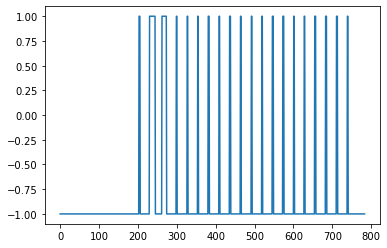

In [24]:
plt.plot(features[0])

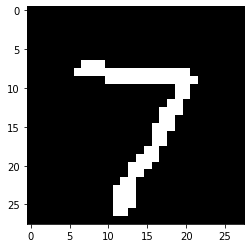

In [25]:
plt.imshow(np.reshape(features[0],(28,28)),cmap='gray')

In [26]:
def one_hot(x):
    res=-torch.ones((len(x),output_size))
    for i in range(len(x)):
        res[i][x[i]]=1
    return res

# Train

In [29]:
net=FCN(width,depth,input_size,output_size)
net.apply(init_weights)
loss=nn.MultiMarginLoss(p=2,margin=margin)
optimizer=optim.SGD(net.parameters(),lr=learning_rate,momentum=momentum)
# optimizer=optim.AdamW(net.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
# scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=4,verbose=True)

param_list=[]
params=[param.detach().tolist() for param in net.parameters()]
param_list.append(params)
losses=[]
# rates=[scheduler.get_last_lr()]
    
with torch.no_grad():
    batch_err=[]
    for imgs, labels in test_loader:
        preds=torch.argmax(net(imgs),axis=1)
        misses=0
        for j in range(len(preds)):
            if preds[j]!=labels[j]: misses+=1
        batch_err.append(misses/len(preds))
err_rates=[np.mean(batch_err)]

100%|██████████| 500/500 [3:23:01<00:00, 24.36s/it]  


Test accuracy: 0.9734


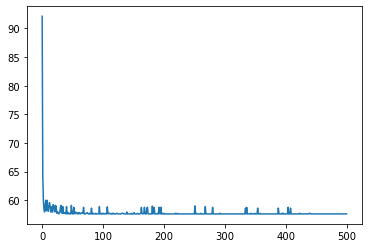

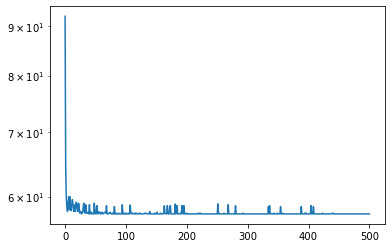

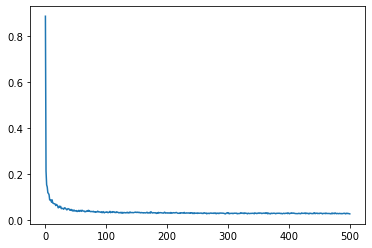

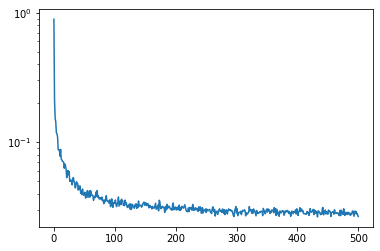

In [30]:
first=True
step_count=0

for epoch in tqdm(range(n_epochs)):
    for i, (imgs, labels) in enumerate(train_loader):
        labels=labels.type(dtype=torch.long)
        optimizer.zero_grad()
        #forward pass
        Y_preds=net(imgs)

        loss_step=loss(Y_preds,labels)
        
        #comment out to not save first loss
        if first:
            losses.append(float(loss_step.detach().numpy()))
            first=False

        #backward pass
        loss_step.backward()
        optimizer.step()
        
    if epoch%step==step-1:
        losses.append(float(loss_step.detach().numpy()))
        params=[param.detach().tolist() for param in net.parameters()]
        param_list.append(params)

        with torch.no_grad():
            batch_err=[]
            for imgs, labels in test_loader:
                preds=torch.argmax(net(imgs),axis=1)
                misses=0
                for j in range(len(preds)):
                    if preds[j]!=labels[j]: misses+=1
                batch_err.append(misses/len(preds))
            err_rates.append(np.mean(batch_err))
            

with torch.no_grad():
    batch_acc=[]
    for imgs, labels in test_loader:
        preds=torch.argmax(net(imgs),axis=1)
        misses=0
        for j in range(len(preds)):
            if preds[j]!=labels[j]: misses+=1
        batch_acc.append(1-misses/len(preds))
    acc=np.mean(batch_acc)
print(f'Test accuracy: {acc:0.4f}')

plt.plot(losses)
plt.show()
plt.plot(losses)
plt.yscale('log')
plt.show()

plt.plot(err_rates)
plt.show()
plt.plot(err_rates)
plt.yscale('log')
plt.show()

# plt.plot(rates)

# Save Data

In [ ]:
epochs=len(param_list)*step

In [34]:
out_dict={
    "learning_rate": learning_rate,
    "gamma": gamma,
    "margin": margin,
    "momentum": momentum,
    "batch_size": batch_size_train,
    "epochs": (len(param_list)-1)*step,
    "input_size": input_size,
    "output_size": output_size,
    "depth": depth,
    "width": width,
    "test_accuracy": acc,
    "losses": losses,
    "err_rates": err_rates,
    "step": step,
    "parameters": param_list
}

name_out="train_data/mnist_paper_lr-4_2.json"

with open(name_out,"w") as outfile:
    json.dump(out_dict,outfile)